Last updated on 2023/4/11

# Code refactoring for release v0.7.0

This is to compare analysis results produced from f2py and the refactored python module.

In [1]:
import numpy as np
from numpy import dtype
from math import pi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from hn2016_falwa.oopinterface import QGField
from hn2016_falwa.plot_utils import compare_two_fields
import hn2016_falwa.utilities as utilities
import datetime as dt

In [2]:
!pwd

/Users/claresyhuang/Dropbox/GitHub/hn2016_falwa/scripts/migration_value_check


# Load ERA-Interim reanalysis data retrieved from ECMWF server
The data is located at `hn2016_falwa/scripts/nh2018_science`

In [3]:
data_path = '/Users/claresyhuang/Dropbox/GitHub/hn2016_falwa/scripts/nh2018_science/'
# --- Load the zonal wind and QGPV at 240hPa --- #
u_file = Dataset(f'{data_path}2005-01-23_to_2005-01-30_u.nc', mode='r')
v_file = Dataset(f'{data_path}2005-01-23_to_2005-01-30_v.nc', mode='r')
t_file = Dataset(f'{data_path}2005-01-23_to_2005-01-30_t.nc', mode='r')

time_array = u_file.variables['time'][:]
time_units = u_file.variables['time'].units
time_calendar = u_file.variables['time'].calendar
ntimes = time_array.shape[0]

print('Dimension of time: {}'.format(time_array.size))

Dimension of time: 32


# Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [4]:
xlon = u_file.variables['longitude'][:]

# latitude has to be in ascending order
ylat = u_file.variables['latitude'][:]
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.variables['level'][:]
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.
Flip plev.


In [5]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

# Set the level of pressure and the timestamp to display below

In [6]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep = 0

# Set names of the variables to display

# Loop through the input file and store all the computed quantities in a netCDF file

In [7]:
uu = u_file.variables['u'][tstep, ::-1, ::-1, :].data
vv = v_file.variables['v'][tstep, ::-1, ::-1, :].data
tt = t_file.variables['t'][tstep, ::-1, ::-1, :].data

In [8]:
qgfield_object_original = QGField(xlon, ylat, plev, uu, vv, tt)
original = qgfield_object_original.interpolate_fields()
qgfield_object_refactored_nh18 = QGField(xlon, ylat, plev, uu, vv, tt)
refactored_nh18 = qgfield_object_refactored_nh18.interpolate_fields_nh18()


/Users/claresyhuang/Dropbox/GitHub/hn2016_falwa/hn2016_falwa/oopinterface.py:100: UserWarning: ylat is a masked array of dimension (121,) with 0 masked elements and fill value 1e+20. 
  warnings.warn(


Debug: route 1.1
equator_idx = 61
In compute_static_stability. Boundary treatment: nh18. dz: 1000.0.
In compute_static_stability. Boundary treatment: nh18. dz: 1000.0.
Debug: route 2.1
smooth_stretch_term = True
strc.shape = (47, 61, 240)
smooth_stretch_term = True
strc.shape = (47, 61, 240)


In [9]:
qgfield_object_original2 = QGField(xlon, ylat, plev, uu, vv, tt)
original_nhn22 = qgfield_object_original2._interpolate_field_dirinv()
qgfield_object_refactored_nhn22 = QGField(xlon, ylat, plev, uu, vv, tt)
refactored_nhn22 = qgfield_object_refactored_nhn22.interpolate_fields_nhn22()

 nlon, nlat, nlev, kmax, jd
         240         121          37          49          61
Debug: route 1.1
equator_idx = 61
In compute_static_stability. Boundary treatment: nhn22. dz: 1000.0.
In compute_static_stability. Boundary treatment: nhn22. dz: 1000.0.
Debug: route 2.2
smooth_stretch_term = False
strc.shape = (47, 61, 240)
smooth_stretch_term = False
strc.shape = (47, 61, 240)


## 1. Comparing Static Stability produced from f2py and python code

- Interpolated fields are idential.

### NH18 case
- Almost the same.

### NHN22 case
- Difference.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


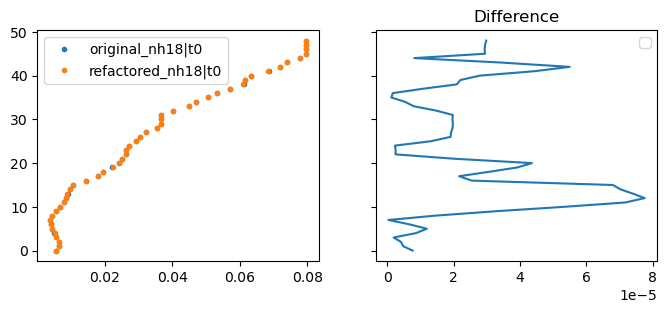

In [10]:
# Compare t0 in NH18
plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
plt.subplot(121)
plt.plot(original.Static_stability, np.arange(49), '.', label='original_nh18|t0')
plt.plot(refactored_nh18.Static_stability, np.arange(49), '.', label='refactored_nh18|t0')
plt.legend()
plt.subplot(122)
plt.plot(np.abs(refactored_nh18.Static_stability-original.Static_stability), 
         np.arange(49))
plt.title('Difference')
plt.legend()
plt.show()

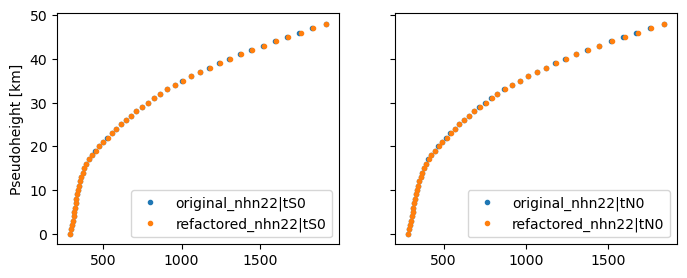

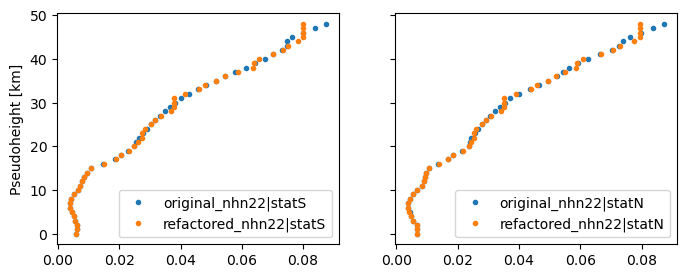

In [11]:
# Compare t0
plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
plt.subplot(121)
plt.plot(original_nhn22[8], np.arange(49), '.', label='original_nhn22|tS0')
plt.plot(refactored_nhn22.t0[0], np.arange(49), '.', label='refactored_nhn22|tS0')
plt.ylabel('Pseudoheight [km]')
plt.legend()
plt.subplot(122)
plt.plot(original_nhn22[7], np.arange(49), '.', label='original_nhn22|tN0')
plt.plot(refactored_nhn22.t0[1], np.arange(49), '.', label='refactored_nhn22|tN0')
plt.legend()
plt.show()

# Compare static stability
plt.subplots(1,2, figsize=(8,3), sharex=False, sharey=True)
plt.subplot(121)
plt.plot(original_nhn22[6], np.arange(49), '.', label='original_nhn22|statS')
plt.plot(refactored_nhn22.Static_stability[0], np.arange(49), '.', label='refactored_nhn22|statS')
plt.ylabel('Pseudoheight [km]')
plt.legend()
plt.subplot(122)
plt.plot(original_nhn22[5], np.arange(49), '.', label='original_nhn22|statN')
plt.plot(refactored_nhn22.Static_stability[1], np.arange(49), '.', label='refactored_nhn22|statN')
plt.legend()
plt.show()

## 2. Comparing QGPV produced from f2py and python code

- Interpolated fields are idential.

### NH18 case
- For QGPV, there is < 1% difference in values which is acceptable.

### NHN22 case
- NHN22 computes QGPV for the full domain. The refactored code is missing the equator. Fix that.


cmin = -0.0004666589481135204, cmax = 0.0005514659089758181


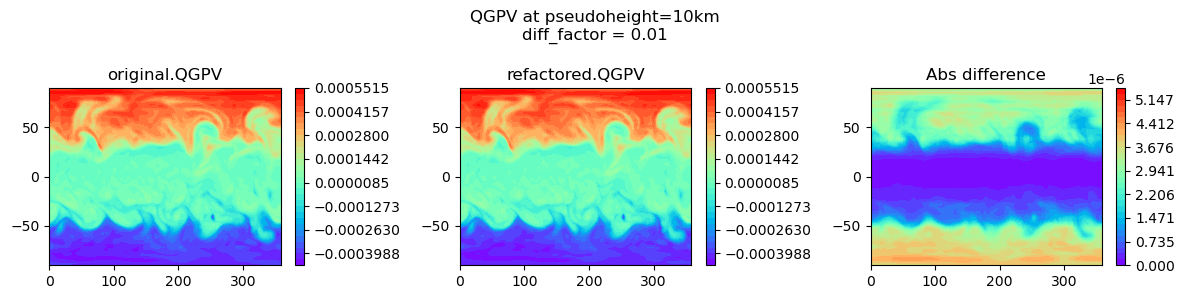

cmin = -9.815204975893721e-05, cmax = 0.00018598203314468265


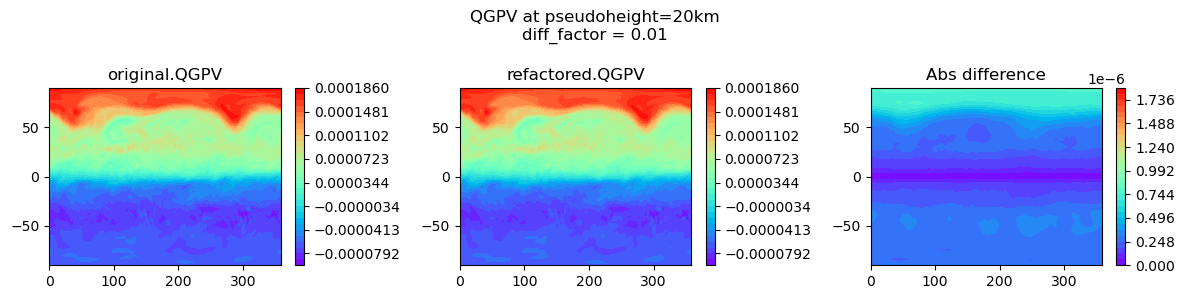

cmin = -0.00013553294411394745, cmax = 0.0002513098297640681


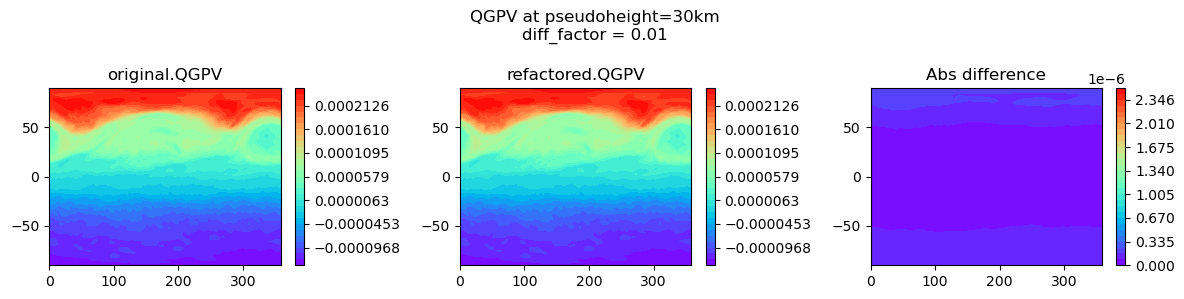

cmin = -0.0001239222166016812, cmax = 0.00029846777531146646


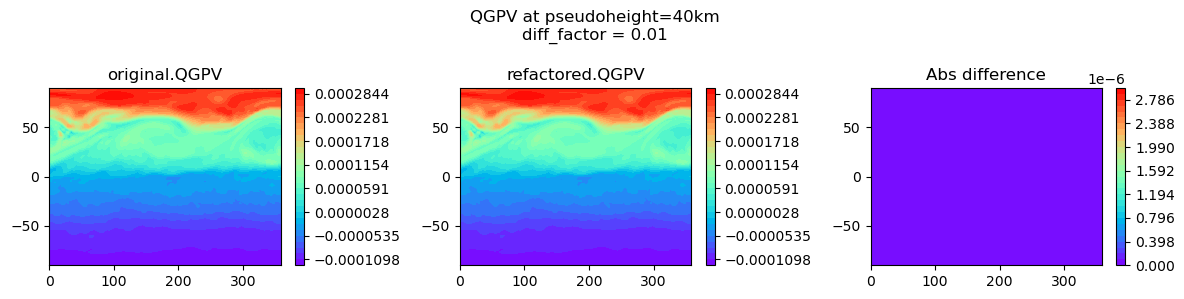

In [12]:
diff_factor = 0.01
for hlev in [10, 20, 30, 40]:
    compare_two_fields(
        field_a=original.QGPV[hlev,:,:],
        field_b=refactored_nh18.QGPV[hlev,:,:], 
        a_title='original.QGPV',
        b_title='refactored.QGPV', 
        x_coord=xlon, 
        y_coord=ylat, 
        title=f"QGPV at pseudoheight={int(height[hlev]/1000.)}km\ndiff_factor = {diff_factor}", 
        savefig_file=None, 
        diff_factor=diff_factor, 
        figsize=(12, 3))

# Compare procedures for NHN22

cmin = -0.00048488040920346975, cmax = 0.0004928868729621172


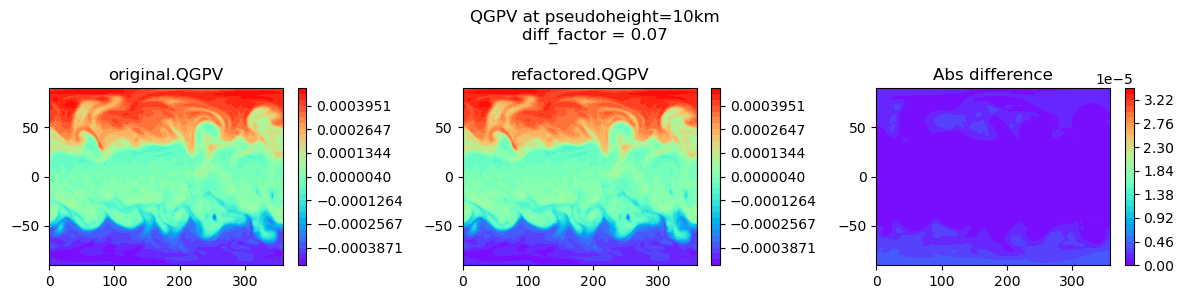

cmin = -0.00016215663345064968, cmax = 0.0002406215644441545


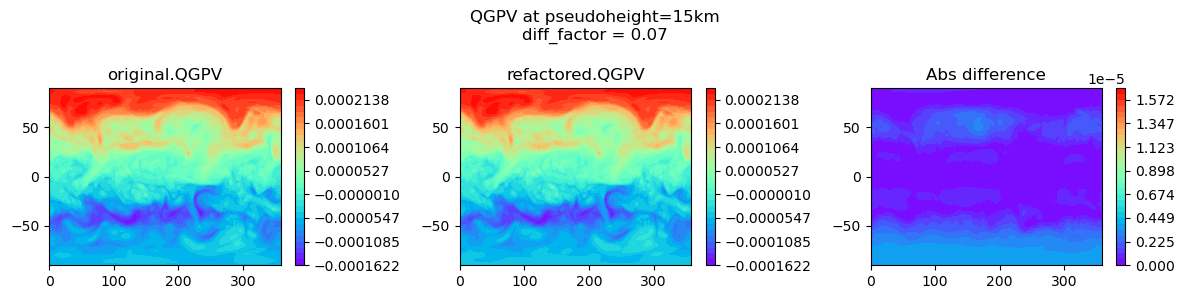

cmin = -9.92928835330531e-05, cmax = 0.00018397904323545444


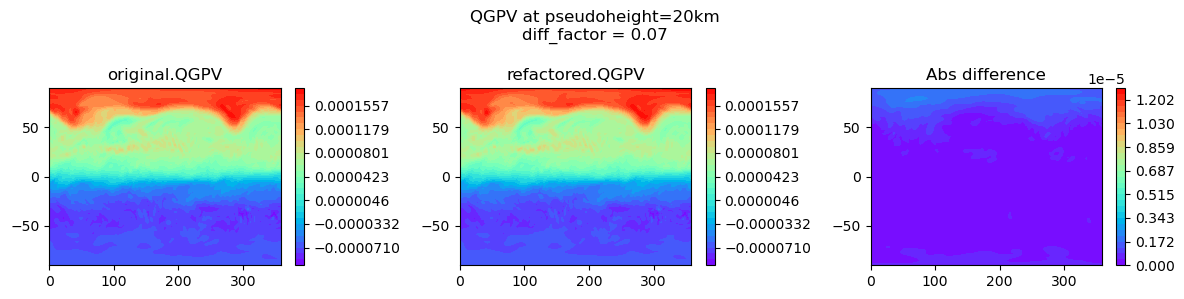

cmin = -0.00010882910282816738, cmax = 0.00024229383357355158


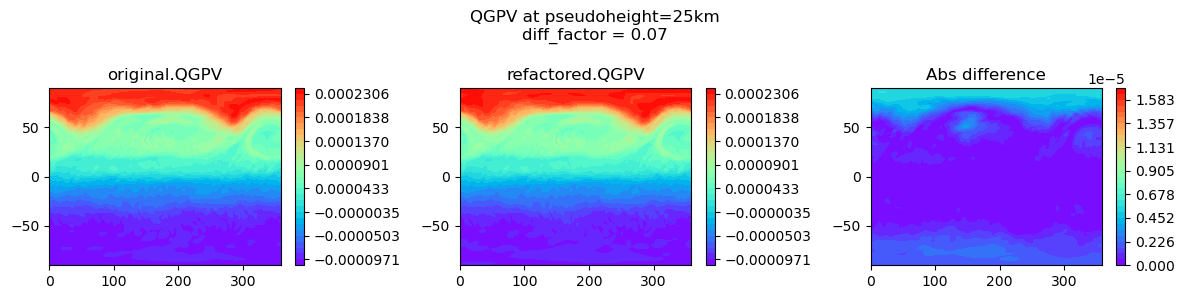

cmin = -0.0001391701186547976, cmax = 0.00025067146634683013


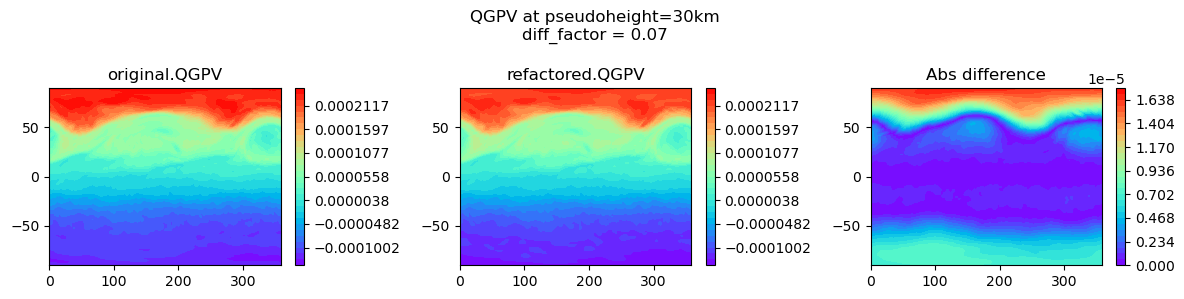

cmin = -0.00012644425441976637, cmax = 0.0002663104938091837


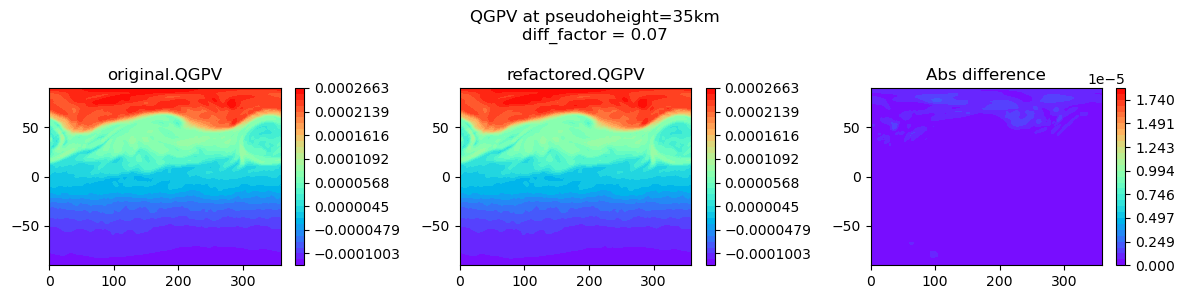

cmin = -0.00013592015602625906, cmax = 0.00027163412957784014


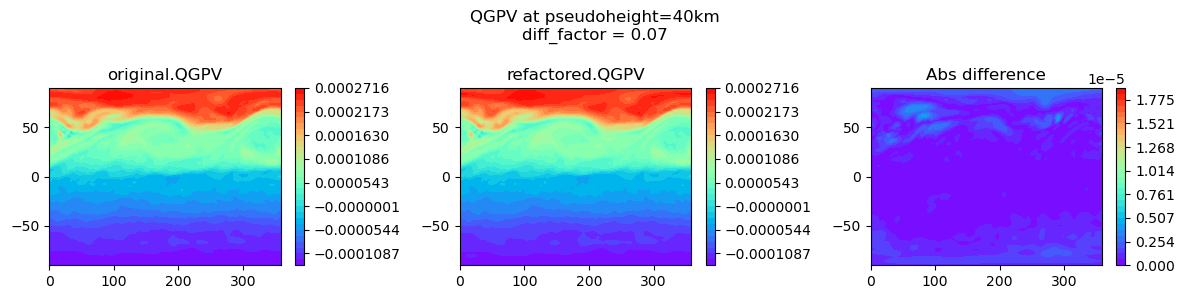

In [15]:
diff_factor = 0.07
for hlev in [10, 15, 20, 25, 30, 35, 40]:
    compare_two_fields(
        field_a=np.swapaxes(original_nhn22[0], 0, 2)[hlev,:,:],
        field_b=refactored_nhn22.QGPV[hlev,:,:], 
        a_title='original.QGPV',
        b_title='refactored.QGPV', 
        x_coord=xlon, 
        y_coord=ylat, 
        title=f"QGPV at pseudoheight={int(height[hlev]/1000.)}km\ndiff_factor = {diff_factor}", 
        savefig_file=None, 
        diff_factor=diff_factor, 
        figsize=(12, 3))